# <center>Eco481 - Project

# <center> Brent Oil - Binary

## Import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

MessageError: ignored

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder,MinMaxScaler

# Machine learning models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation
from sklearn.metrics import mean_squared_error,accuracy_score,confusion_matrix, ConfusionMatrixDisplay

import pickle

## Read Target Dataset - WTI Crude Oil

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/ECO481-Final Project/dataset/Brent Oil Daily.csv')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

In [ ]:
df = df.sort_values(by='Date').reset_index(drop=True)

## Feature Engineering

https://medium.com/analytics-vidhya/stock-trend-prediction-with-technical-indicators-feature-engineering-and-python-code-1fa54d5806ba

### Lagged Price

In [ ]:
df['lag_daily'] = df['Price'].shift(1)
df['lag_weekly'] = df['Price'].shift(5)
df['lag_biweekly'] = df['Price'].shift(10)
df['lag_monthly'] = df['Price'].shift(20)

### Price Difference

In [ ]:
df['diff_daily'] = df['Price'] - df['Price'].shift(1)
df['diff_weekly'] = df['Price'] - df['Price'].shift(5)
df['diff_biweekly'] = df['Price'] - df['Price'].shift(10)
df['diff_monthly'] = df['Price'] - df['Price'].shift(20)

### Returns

In [ ]:
df['return_daily'] = round((df['Price'] - df['Price'].shift(1)) / df['Price'].shift(1) * 100, 2)
df['return_weekly'] = round((df['Price'] - df['Price'].shift(5)) / df['Price'].shift(5) * 100, 2)
df['return_biweekly'] = round((df['Price'] - df['Price'].shift(10)) / df['Price'].shift(10) * 100, 2)
df['return_monthly'] = round((df['Price'] - df['Price'].shift(20)) / df['Price'].shift(20) * 100, 2)

### Simple Moving Average

In [ ]:
df['sma_daily'] = df['Price'].rolling(1).mean()
df['sma_weekly'] = df['Price'].rolling(5).mean()
df['sma_biweekly'] = df['Price'].rolling(10).mean()
df['sma_monthly'] = df['Price'].rolling(20).mean()

### Exponential Weighted Moving Average



In [ ]:
df['ewm_daily'] = df['Price'].ewm(span=1).mean()
df['ewm_weekly'] = df['Price'].ewm(span=5).mean()
df['ewm_biweekly'] = df['Price'].ewm(span=10).mean()
df['ewm_monthly'] = df['Price'].ewm(span=20).mean()

### Average True Range

https://www.investopedia.com/terms/a/atr.asp

In [ ]:
high_low = df['High'] - df['Low']
high_close = np.abs(df['High'] - df['Price'].shift())
low_close = np.abs(df['Low'] - df['Price'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
df['atr'] = true_range.rolling(14).sum()/14

### Date-related Features

In [ ]:
df['dayofweek'] = df['Date'].dt.dayofweek
df['quarter'] = df['Date'].dt.quarter
df['month'] = df['Date'].dt.month
df['year'] = df['Date'].dt.year
df['dayofyear'] = df['Date'].dt.dayofyear
df['dayofmonth'] = df['Date'].dt.day
df['weekofyear'] = df['Date'].dt.weekofyear

<ipython-input-12-fbfc8ac8aa8a>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['Date'].dt.weekofyear


In [ ]:
len(df)

2602

In [ ]:
len(df.dropna())

2577

## External Variables

In [ ]:
external_df = pd.read_excel('/content/gdrive/MyDrive/ECO481-Final Project/dataset updated 2/Final Dataset.xlsx',index_col=0)

In [ ]:
external_df['Date']=pd.to_datetime(external_df['Date'])
external_df.set_index('Date')
external_df

,Date,Brent_price,WTI_price,Gold_price,GPR,Sp500,USD_EUR,USD_CAD,TSX,MSCI_index,...,HDD,CDD,Drought Index,Consumer Index,Nature gas price,OPEC Total Crude Oil Production,OPEC Total Crude Oil Production Capacity,Oil Inventory,US GDP,CPI
0,2013-02-01,116.76,97.77,"1,670.60",81.590332,"1,506.75",0.7326,1.003311,12768.799805,"1,072.82",...,738.0,10.0,-4.9,77.6,3.301,29.29,32.56,1039081,99.888699,232.166
1,2013-02-04,115.60,96.17,"1,676.40",81.590332,"1,493.50",0.7399,1.003210,12717.599609,"1,072.73",...,738.0,10.0,-4.9,77.6,3.315,29.29,32.56,1039081,99.888699,232.166
2,2013-02-05,116.52,96.64,"1,673.50",81.590332,"1,506.00",0.7365,1.002305,12745.700195,"1,067.61",...,738.0,10.0,-4.9,77.6,3.399,29.29,32.56,1039081,99.888699,232.166
3,2013-02-06,116.73,96.62,"1,678.80",81.590332,"1,506.75",0.7397,1.004601,12761.599609,"1,063.75",...,738.0,10.0,-4.9,77.6,3.418,29.29,32.56,1039081,99.888699,232.166
4,2013-02-07,117.24,95.83,"1,671.30",81.590332,"1,505.25",0.7464,1.004520,12755.900391,"1,059.56",...,738.0,10.0,-4.9,77.6,3.285,29.29,32.56,1039081,99.888699,232.166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,2023-02-22,80.45,73.95,"1,833.30",NaN,"3,999.00",0.9430,0.738831,20193.300781,982.06,...,NaN,NaN,NaN,NaN,2.174,28.42,31.64,850620,NaN,300.840
2596,2023-02-23,81.95,75.39,"1,818.80",NaN,"4,018.75",0.9436,0.738258,20188.199219,987.74,...,NaN,NaN,NaN,NaN,2.314,28.42,31.64,850620,NaN,300.840
2597,2023-02-24,82.82,76.32,"1,809.20",NaN,"3,975.75",0.9479,0.738378,20219.199219,971.87,...,NaN,NaN,NaN,NaN,2.451,28.42,31.64,851786,NaN,300.840
2598,2023-02-27,82.07,75.74,"1,824.00",NaN,"3,988.00",0.9425,0.735635,20260.099609,967.25,...,NaN,NaN,NaN,NaN,2.731,28.42,31.64,851786,NaN,300.840


## Data Preprocessing

### Merge Data

In [ ]:
# join engineered features with external features
# drop useless columns and NaNs
#external_df['Date']=external_df.index
finaldf = pd.merge(df, external_df, on="Date", how="left")
finaldf = finaldf.set_index('Date')
finaldf = finaldf.drop(['Open','High','Low','Vol.','Change %'], axis=1)

In [ ]:
finaldf['binaryTarget'] = finaldf.rolling(5).apply(lambda x: int(x.iloc[4] > x.iloc[0]))["Price"]

<ipython-input-18-f6ee964b9360>:1: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Gold_price', 'MSCI_index', 'Sp500'], dtype='object')
  finaldf['binaryTarget'] = finaldf.rolling(5).apply(lambda x: int(x.iloc[4] > x.iloc[0]))["Price"]


In [ ]:
finaldf['binaryTarget'] = finaldf['binaryTarget'].shift(-5).astype('Int64')

In [ ]:
finaldf.drop('Price',inplace=True,axis=1)

In [ ]:
finaldf.drop('Brent_price',inplace=True,axis=1)

In [ ]:
finaldf.dropna(inplace=True)

In [ ]:
finaldf

,lag_daily,lag_weekly,lag_biweekly,lag_monthly,diff_daily,diff_weekly,diff_biweekly,diff_monthly,return_daily,return_weekly,...,CDD,Drought Index,Consumer Index,Nature gas price,OPEC Total Crude Oil Production,OPEC Total Crude Oil Production Capacity,Oil Inventory,US GDP,CPI,binaryTarget
Date,,,,,,,,,,,,,,,,,,,,,
2013-03-01,111.38,114.10,117.66,116.76,-0.98,-3.70,-7.26,-6.36,-0.88,-3.24,...,10.0,-5.18,78.6,3.456,29.45,32.72,1048812.0,99.887151,232.773,1
2013-03-04,110.40,114.44,117.38,115.60,-0.31,-4.35,-7.29,-5.51,-0.28,-3.80,...,10.0,-5.18,78.6,3.529,29.45,32.72,1048812.0,99.887151,232.773,0
2013-03-05,110.09,112.71,117.52,116.52,1.52,-1.10,-5.91,-4.91,1.38,-0.98,...,10.0,-5.18,78.6,3.529,29.45,32.72,1048812.0,99.887151,232.773,0
2013-03-06,111.61,111.87,115.60,116.73,-0.55,-0.81,-4.54,-5.67,-0.49,-0.72,...,10.0,-5.18,78.6,3.470,29.45,32.72,1048812.0,99.887151,232.773,0
2013-03-07,111.06,111.38,113.53,117.24,0.09,-0.23,-2.38,-6.09,0.08,-0.21,...,10.0,-5.18,78.6,3.582,29.45,32.72,1048812.0,99.887151,232.773,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-26,91.74,90.56,92.45,89.32,3.95,5.13,3.24,6.37,4.31,5.66,...,51.0,-3.63,59.9,5.606,29.20,31.23,841663.0,99.930849,298.012,0
2022-10-27,95.69,90.45,94.57,88.49,1.27,6.51,2.39,8.47,1.33,7.20,...,51.0,-3.63,59.9,5.186,29.20,31.23,841663.0,99.930849,298.012,0
2022-10-28,96.96,91.34,90.15,87.96,-1.19,4.43,5.62,7.81,-1.23,4.85,...,51.0,-3.63,59.9,5.684,29.20,31.23,836622.0,99.930849,298.012,1


### Check Data Types

In [ ]:
# check OBJECT data type
finaldf['Gold_price'].dtypes

dtype('O')

In [ ]:
# check OBJECT data type
finaldf['MSCI_index'].dtypes

dtype('O')

In [ ]:
# check OBJECT data type
finaldf['Sp500'].dtypes

dtype('O')

In [ ]:
finaldf['Gold_price'] = finaldf['Gold_price'].apply(lambda x: float(x.replace(',','')))
finaldf['MSCI_index'] = finaldf['MSCI_index'].apply(lambda x: float(x.replace(',','')))
finaldf['Sp500'] = finaldf['Sp500'].apply(lambda x: float(x.replace(',','')))

In [ ]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2422 entries, 2013-03-01 to 2022-11-01
Data columns (total 48 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   lag_daily                                 2422 non-null   float64
 1   lag_weekly                                2422 non-null   float64
 2   lag_biweekly                              2422 non-null   float64
 3   lag_monthly                               2422 non-null   float64
 4   diff_daily                                2422 non-null   float64
 5   diff_weekly                               2422 non-null   float64
 6   diff_biweekly                             2422 non-null   float64
 7   diff_monthly                              2422 non-null   float64
 8   return_daily                              2422 non-null   float64
 9   return_weekly                             2422 non-null   float64
 10  return_biweekly   

### Train test split

In [ ]:
idx = 1695

In [ ]:
# split training and test data based a index
X_train = finaldf.drop(columns = ["binaryTarget"]).iloc[:idx]
X_test = finaldf.drop(columns = ["binaryTarget"]).iloc[idx: ]

y_train = finaldf["binaryTarget"].iloc[:idx]
y_test = finaldf["binaryTarget"].iloc[idx: ]

### Scaling

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Implementation

### Time Series CV

In [ ]:
ts_cr_val = TimeSeriesSplit()

In [ ]:
def make_predictions(model):
  model.fit(X_train_scaled, y_train)
  print("The Training Accuracy is:",accuracy_score(model.predict(X_train_scaled),y_train),'\n')
  model_predictions = model.predict(X_test_scaled)
  print('The Test Accuracy is:',accuracy_score(y_test,model_predictions))
  return model_predictions,accuracy_score(model.predict(X_train_scaled),y_train),accuracy_score(y_test,model_predictions)

In [ ]:
# create a funtion to draw graphs
def plot_comparison(predictions, targets,title):
  # plt.figure(figsize=(4,4))
  cm = confusion_matrix(targets, predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title(title)
  plt.show()

### 1. Dummy Classifier

This regressor is used to set up a benchmark or baseline for this regression analysis

In [ ]:
dm_predictions, dm_train_acc, dm_test_acc = make_predictions(DummyClassifier())

The Training Accuracy is: 0.5026548672566372 

The Test Accuracy is: 0.5708390646492435


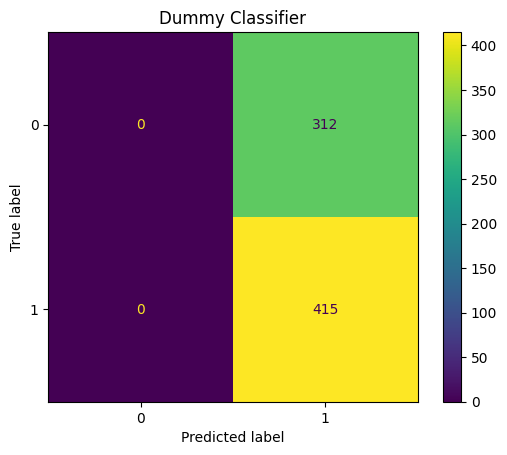

In [ ]:
plot_comparison(dm_predictions,y_test,'Dummy Classifier')

### 2. Logistic Regression

In [ ]:
lr = LogisticRegression()
param_search = {"solver":["lbfgs","liblinear",'newton-cg','sag','saga'],
                'C':[0.1, 0.01,0.005,0.001,0.0001]}

lr_gsearch = GridSearchCV(estimator=lr, cv=ts_cr_val, scoring='accuracy',param_grid=param_search,n_jobs=-1)
lr_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.1, 0.01, 0.005, 0.001, 0.0001],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag',
                                    'saga']},
             scoring='accuracy')

In [ ]:
lr_gsearch.best_estimator_

LogisticRegression(C=0.0001, solver='liblinear')

In [ ]:
lr_predictions, lr_train_acc, lr_test_acc = make_predictions(lr_gsearch.best_estimator_)

The Training Accuracy is: 0.567551622418879 

The Test Accuracy is: 0.5887207702888583


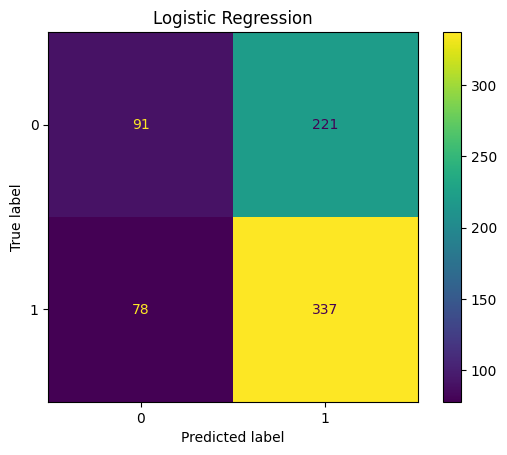

In [ ]:
plot_comparison(lr_predictions,y_test,'Logistic Regression')

### 3. KNN

In [ ]:
knn = KNeighborsClassifier()
param_search = {'n_neighbors': [2,4,6,8,10,20,30],
                'weights': ['uniform','distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute'],
                'p':[1,2]}

knn_gsearch = GridSearchCV(estimator=knn, cv=ts_cr_val, param_grid=param_search,scoring='accuracy',n_jobs=-1)
knn_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [2, 4, 6, 8, 10, 20, 30], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy')

In [ ]:
knn_gsearch.best_estimator_

KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

In [ ]:
knn_predictions, knn_train_acc, knn_test_acc = make_predictions(knn_gsearch.best_estimator_)

The Training Accuracy is: 1.0 

The Test Accuracy is: 0.4951856946354883


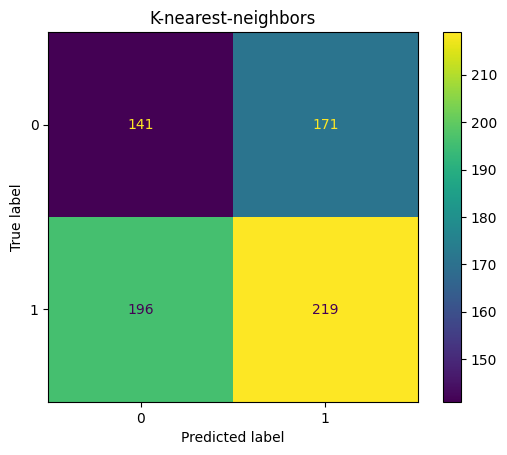

In [ ]:
plot_comparison(knn_predictions,y_test,'K-nearest-neighbors')

### 4. Naive Bayes

In [ ]:
nb = GaussianNB()
param_search = {'var_smoothing': np.logspace(0,-9, num=100)}
nb_gsearch = GridSearchCV(estimator=nb, cv=ts_cr_val, param_grid=param_search,scoring='accuracy',n_jobs=-1)
nb_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6....
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy')

In [ ]:
nb_gsearch.best_estimator_

GaussianNB(var_smoothing=0.08111308307896872)

In [ ]:
nb_predictions, nb_train_acc, nb_test_acc = make_predictions(nb_gsearch.best_estimator_)

The Training Accuracy is: 0.5551622418879056 

The Test Accuracy is: 0.5777166437414031


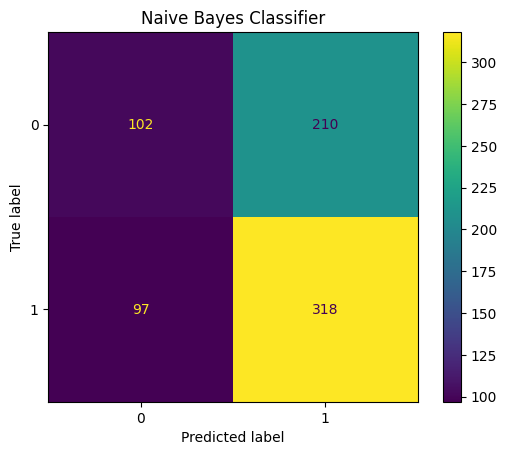

In [ ]:
plot_comparison(nb_predictions,y_test,'Naive Bayes Classifier')

### 5. Decision Tree

In [ ]:
dt = DecisionTreeClassifier()
param_search = {"max_depth" : [1,2,3,5,7],
                "min_samples_leaf":[1,3,5,7,8,10],
                "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
                "max_leaf_nodes":[None,10,20,30,50,70,80,90] }

dt_gsearch = GridSearchCV(estimator=dt, cv=ts_cr_val, scoring='accuracy',param_grid=param_search,n_jobs=-1)
dt_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 5, 7],
                         'max_leaf_nodes': [None, 10, 20, 30, 50, 70, 80, 90],
                         'min_samples_leaf': [1, 3, 5, 7, 8, 10],
                         'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5]},
             scoring='accuracy')

In [ ]:
dt_predictions, dt_train_acc, dt_test_acc = make_predictions(dt_gsearch.best_estimator_)

The Training Accuracy is: 0.6206489675516225 

The Test Accuracy is: 0.5075653370013755


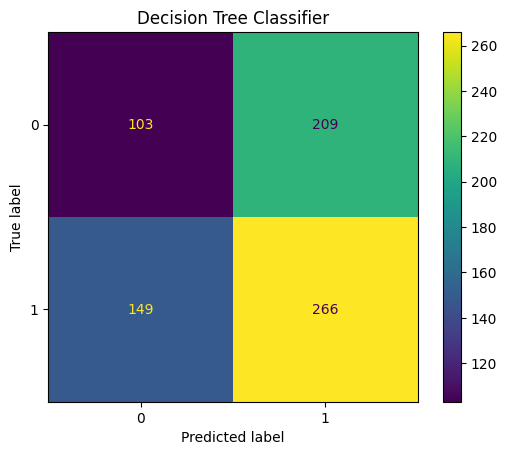

In [ ]:
plot_comparison(dt_predictions, y_test,'Decision Tree Classifier')

### 6. Random Forest

In [ ]:
rf = RandomForestClassifier()
param_search = {'max_depth': [1,2,3],
                'max_features': ['sqrt','log2',None],
                'min_samples_split': [2,5,10],
                'ccp_alpha': [0,0.01,0.1,1,10]}

rf_gsearch = GridSearchCV(estimator=rf, cv=ts_cr_val, param_grid=param_search,scoring='accuracy',n_jobs=-1)
rf_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'max_depth': [1, 2, 3],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

In [ ]:
rf_gsearch.best_estimator_

RandomForestClassifier(ccp_alpha=0, max_depth=1, max_features='log2',
                       min_samples_split=10)

In [ ]:
rf_predictions, rf_train_acc, rf_test_acc = make_predictions(rf_gsearch.best_estimator_)

The Training Accuracy is: 0.5793510324483776 

The Test Accuracy is: 0.5845942228335625


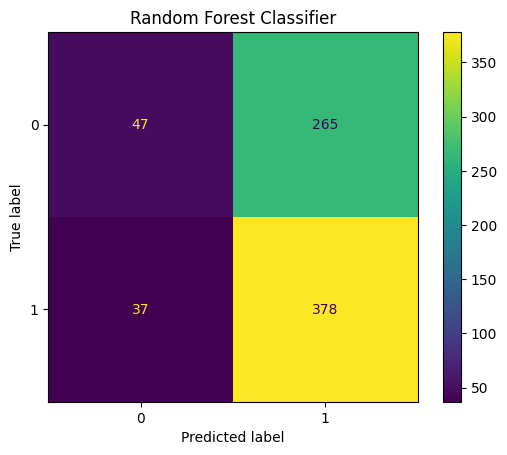

In [ ]:
plot_comparison(rf_predictions, y_test,'Random Forest Classifier')

### 7. Gradient Boosting

In [ ]:
gbt = GradientBoostingClassifier()
param_search = {'learning_rate':[0.001,0.01,0.1],
                'max_depth':[2,6,10],
                'max_features': ['sqrt','log2',None],
                'min_samples_split': [5,10,20],
                'ccp_alpha': [0,0.01,0.1,1,10]}

gbt_gsearch = GridSearchCV(estimator=gbt, cv=ts_cr_val, param_grid=param_search,scoring='accuracy',n_jobs=-1)
gbt_gsearch.fit(X_train_scaled, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'ccp_alpha': [0, 0.01, 0.1, 1, 10],
                         'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [2, 6, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_split': [5, 10, 20]},
             scoring='accuracy')

In [ ]:
gbt_gsearch.best_estimator_

GradientBoostingClassifier(ccp_alpha=0, max_depth=10, min_samples_split=5)

In [ ]:
gbt_predictions, gbt_train_acc, gbt_test_acc = make_predictions(gbt_gsearch.best_estimator_)

The Training Accuracy is: 1.0 

The Test Accuracy is: 0.41815680880330125


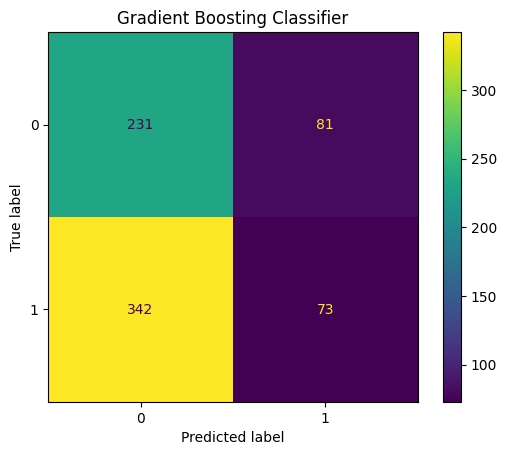

In [ ]:
plot_comparison(gbt_predictions, y_test,'Gradient Boosting Classifier')

In [ ]:
print('Brent Oil Price - Binary')
pd.DataFrame(
    {
     'Training Accuracy':[dm_train_acc,lr_train_acc,knn_train_acc,nb_train_acc,dt_train_acc,rf_train_acc,gbt_train_acc],
     'Test Accuracy':[dm_test_acc,lr_test_acc,knn_test_acc,nb_test_acc,dt_test_acc,rf_test_acc,gbt_test_acc]
    },
    index = ['Dummy','Logistic Regression','K-nearest-neighbors','Naive Bayes','Decision Tree','Random Forest','Gradient Boosting']
)*100

Brent Oil Price - Binary


,Training Accuracy,Test Accuracy
Dummy,50.265487,57.083906
Logistic Regression,56.755162,58.872077
K-nearest-neighbors,100.000000,49.518569
Naive Bayes,55.516224,57.771664
Decision Tree,62.064897,50.756534
Random Forest,57.935103,58.459422
Gradient Boosting,100.000000,41.815681


## Feature Importance

Text(0.5, 0, 'Feature Importance')

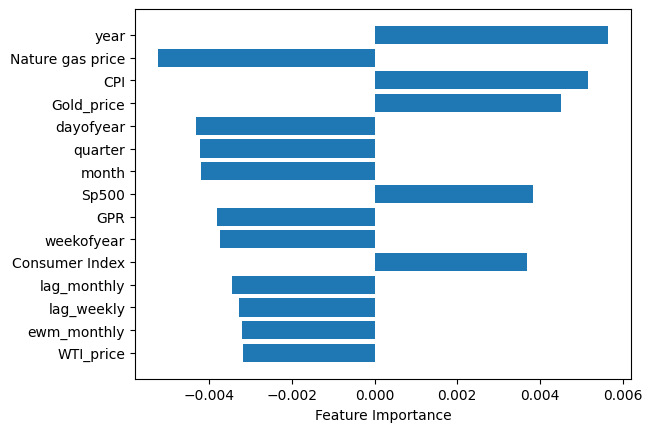

In [ ]:
best_model = lr_gsearch.best_estimator_

best_model.fit(X_train_scaled, y_train)

importance = best_model.coef_[0]
sort = abs(importance).argsort()[-15:]
plt.barh(np.array(X_train.columns)[sort], importance[sort])
plt.xlabel("Feature Importance")

# logit_features = pd.Series(logit.coef_.tolist()[0], index = list(dataframe.columns))
# sorted_logit_features = logit_features.sort_values(ascending = False, key = abs)
# sorted_logit_features[0:5]